# Keras of Flower Photos

### 介绍

展示利用Keras高级深度学习框架，在google经典数据集flower_photos上进行分类识别任务。  
本文的特点是充分利用迁移学习的优点，使用的model架构和参数来自于已经训练好的VGG-16。

### 数据集

数据集来自google的dataset搜索。属于经典数据集，很容易找。  
存放位置于：VGG16_for_flower\flower_photos。  
花卉共有：daisy、dandelion、roses、sunflowers、tulips，分别是：雏菊、蒲公英、玫瑰、向日葵、郁金香。  
下面先读取文件。

In [1]:
from image_untils import *
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.callbacks import TensorBoard


D:\Anacanda\envs\tensorflow1.14.0\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anacanda\envs\tensorflow1.14.0\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anacanda\envs\tensorflow1.14.0\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anacanda\envs\tensorflow1.14.0\lib\site-packages\tensorflow\python\framework

In [2]:
tf.enable_eager_execution()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


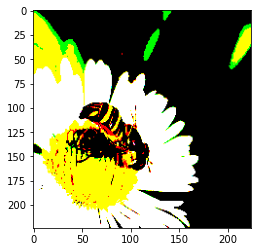

In [3]:
ex_image = load_img('VGG16_for_flower/flower_photos/daisy/5547758_eea9edfd54_n.jpg')
plt.imshow(ex_image)

利用上面的函数批量导入，得到的是一个dict。  
得到的数据将会是被归一化，重整为（244，224）尺寸大小的图片。

In [4]:
x_dict, y = load_data('VGG16_for_flower/flower_photos')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
633
3670


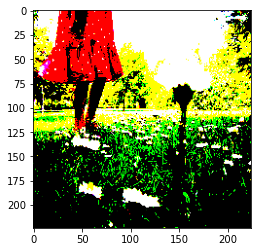

In [5]:
plt.imshow(x_dict['daisy'][7])
print([x for x in x_dict.keys()])
print(len(x_dict['daisy']))
print(len(y))

#### 处理得到标准格式

In [6]:
x = np.concatenate([x_dict[x] for x in x_dict.keys()] , axis=0)
y = np.array(y)

In [7]:
print(x.shape)
print(y.shape)

(3670, 224, 224, 3)
(3670,)


#### 打乱数据和标签

In [8]:
index = [x for x in range(x.shape[0])]
np.random.shuffle(index)
shuffle_x = x[index , :, :, :]
shuffle_y = y[index]

VGG需要对图片的通道进行处理，label需要独热编码化

In [9]:
one_hot_y = to_categorical(shuffle_y, 5)

### 构建model

和一般的不同，我们使用keras提供预训练好了的VGG-16模型，改变其后三层。  
实现迁移学习的目的。

In [10]:
class my_VGG16():
    def __init__(self, class_num, log_path, save_path):
        self.class_num = class_num
        self.log_path = log_path
        self.save_path = save_path
        self.model_vgg = None

    def pretrain_vgg(self):
        model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        model = Flatten(name='Flatten')(model_vgg.output)
        model = Dense(self.class_num, activation='softmax')(model)
        self.model_vgg = Model(inputs=model_vgg.input, outputs=model, name='vgg16')
        #sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
        # sgd效果比Adam更好
        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        self.model_vgg.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
        self.model_vgg.summary()
    
    def train(self,x, y, batch_size=32, epoch=50):
        logs = TensorBoard(log_dir=self.log_path, write_graph=True, write_images=True)
        self.model_vgg.fit(x, y, batch_size=batch_size, epochs=epoch, verbose=1, validation_split=0.3, callbacks=[logs])
    
    def save(self):
        self.model_vgg.save(self.save_path)

    def predict(self, img_path="test.jpg"):
        model = load_model(model_path)
        test_img = load_img()
        ans = model.predict(test_img.reshape(1, 224, 224, 3))
        max_index = np.argmax(ans, axis=1)
        type_dict = {'0': 'daisy', '1': 'dandelion', '2':'roses', '3':'sunflowers', '4':'tulips'}
        print('预测的结果是 %s' % type_dict[str(max_index)])

In [11]:
class_num = 5
log_path = 'VGG16_for_flower/logs'
save_path = 'VGG16_for_flower/model/flowers_5classes.h5'

In [12]:
vgg16 = my_VGG16(class_num, log_path, save_path)

In [13]:
vgg16.pretrain_vgg()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
vgg16.train(shuffle_x, one_hot_y)

Train on 2569 samples, validate on 1101 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
